In [1]:
import numpy as np
import time
import os
import cv2
import sys

In [ ]:
# we can easily adjust the input and network parameter sizes
# Input: (48,80), (96, 160), (144, 240), (192, 320)
# Try to only changing the dense layer parameter number 
# Also try creating more conv layers so that the compressed format is same parameters




In [2]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

In [3]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X_c, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X_c, length_per_mvi)

print("Total time to load small-data is", time.time() - start_time, "seconds")

  0%|          | 0/10421 [00:00<?, ?it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [02:24<00:00, 72.25it/s]
1it [00:00,  3.03it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.97it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:00,  3.71it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.49it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  3.06it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.90it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.99it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


10it [00:02,  3.50it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821
MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.66it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.88it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.38it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small-data is 148.5132520198822 seconds


In [4]:
# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

Xc_train, Xc_test, Y_train_dict, Y_test_dict = _split_train_test(X_c, Y_dict)

In [5]:
# Now cluster the data

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


(540, 960, 3)
(540, 960, 3)


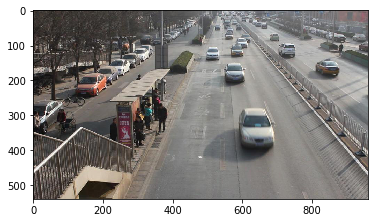

In [6]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(Xc_train[image_index].shape)

example = Xc_train[image_index]
print(example.shape)

plt.imshow(example)

In [58]:
# Must perform normalization for the autoencoder to perform well
Xc_train_norm = np.copy(Xc_train)
Xc_test_norm = np.copy(Xc_test)


def _reform_input(image_table, height, width, grayscale = True):
    # This function could rapidly change according to what we want
    # But the purpose of this function is to feed in the input as per network specifications
    # current specs: convert to size (48, 80) and grayscale

    start_time = time.time()
    assert(len(image_table.shape) == 4)
    n_samples = image_table.shape[0]
    channels = 3
    if grayscale:
        channels = 1
    
    image_array = np.ndarray(shape=(n_samples, height, width, channels))
        
    for i in range(len(image_table)):
        image = image_table[i ,: ,: ,:]
        if grayscale:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
        image = cv2.resize(image, (width, height))
        # might need to expand dimension
        if grayscale:
            image_array[i ,: ,: ,0] = image
        else:
            image_array[i,:,:,:] = image
        
    image_array /= 255.0  # normalize the input for layers
    print("finished reforming input, total time taken is", time.time() - start_time, "seconds")
    return image_array

#size_array = [(24,40), (48,80), (96, 160), (144, 240)]
size_array = [(96, 160)]
X_train_norm_arr = []
X_test_norm_arr = []
for i in range(len(size_array)):
    height, width = size_array[i]
    X_train_norm_arr.append(_reform_input(Xc_train_norm, height, width, grayscale = False))
    X_test_norm_arr.append(_reform_input(Xc_test_norm, height, width, grayscale = False))



finished reforming input, total time taken is 4.724487543106079 seconds
finished reforming input, total time taken is 1.065361499786377 seconds


In [59]:

keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [60]:
# Combined network with both FC and CNN layers

# Input
def build(X_train):
    n_samples, width, height, channels = X_train.shape
    
    input_img = Input(shape=(width, height, channels))
    # Encoder
    x = Conv2D(8,(3,3),
               activation='relu',
               padding='same')(input_img)
    x = Conv2D(8,(3,3),
               activation='relu',
               padding='same')(x)
    x = MaxPooling2D((2,2),
                     padding='same')(x) 
    x = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x = MaxPooling2D((2,2),
                     padding='same')(x) # Size 
    x = Flatten()(x)
    encoded = Dense(256)(x)
    # Decoder
    x = Dense(int(height / 4 * width / 4 * 16))(encoded)
    x = Reshape((int(width / 4), int(height / 4),  16))(x)
    x = UpSampling2D((2, 2))(x) # 24, 40, 16
    x = Conv2D(16, (3, 3),
               activation='relu',
               padding='same')(x)
    x = Conv2D(16, (3, 3),
               activation='relu',
               padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Size 48, 80, 16
    x = Conv2D(8, (3, 3),
               activation='relu',
               padding='same')(x)
    decoded = Conv2D(channels, (3, 3),
               activation='relu',
               padding='same')(x)




    autoencoder = Model(input_img, decoded)

    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.summary()
    return encoder, autoencoder

encoder_arr = []
autoencoder_arr = []

for i in range(len(size_array)):
    enc, aut = build(X_train_norm_arr[i])
    encoder_arr.append(enc)
    autoencoder_arr.append(aut)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 160, 8)        224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 160, 8)        584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 80, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 80, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 80, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 40, 16)        0         
__________

In [61]:
training_time_arr = []
for i in range(len(size_array)):   
    start_time = time.time()
    train_history = autoencoder_arr[i].fit(X_train_norm_arr[i], X_train_norm_arr[i], epochs=200, batch_size=2048, validation_data=(X_test_norm_arr[i], X_test_norm_arr[i]))
    print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")
    training_time_arr.append(time.time() - start_time)
    


Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 18s 2ms/step - loss: 0.2456 - val_loss: 0.0882
Epoch 2/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.1403 - val_loss: 0.1392
Epoch 3/200
8336/8336 [==============================] - 15s 2ms/step - loss: 0.0958 - val_loss: 0.0732
Epoch 4/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0553 - val_loss: 0.0401
Epoch 5/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0427 - val_loss: 0.0333
Epoch 6/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0347 - val_loss: 0.0322
Epoch 7/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0301 - val_loss: 0.0302
Epoch 8/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0285 - val_loss: 0.0286
Epoch 9/200
8336/8336 [==============================] - 14s 2ms/step - loss: 0.0268 - val_loss: 0.0257
Epoch 10/200
833

8336/8336 [==============================] - 13s 2ms/step - loss: 0.0106 - val_loss: 0.0163
Epoch 79/200
8336/8336 [==============================] - 12s 1ms/step - loss: 0.0105 - val_loss: 0.0163
Epoch 80/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0105 - val_loss: 0.0162
Epoch 81/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0104 - val_loss: 0.0162
Epoch 82/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0104 - val_loss: 0.0160
Epoch 83/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0103 - val_loss: 0.0159
Epoch 84/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0103 - val_loss: 0.0169
Epoch 85/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0106 - val_loss: 0.0161
Epoch 86/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0102 - val_loss: 0.0159
Epoch 87/200
8336/8336 [==============================] - 12s 1ms/st

8336/8336 [==============================] - 13s 2ms/step - loss: 0.0075 - val_loss: 0.0143
Epoch 156/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 157/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 158/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 159/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0074 - val_loss: 0.0141
Epoch 160/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0074 - val_loss: 0.0141
Epoch 161/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 162/200
8336/8336 [==============================] - 13s 2ms/step - loss: 0.0075 - val_loss: 0.0141
Epoch 163/200
8336/8336 [==============================] - 12s 1ms/step - loss: 0.0075 - val_loss: 0.0140
Epoch 164/200
8336/8336 [==============================] - 1

In [62]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

#image_table_flattened = image_table.reshape(-1, width*height).astype('float32')
#image_table /= 255.0
def cluster(X_train_norm, X_test_norm, encoder):
    start_time = time.time()
    X_train_compressed = encoder.predict(X_train_norm)
    X_test_compressed = encoder.predict(X_test_norm)
    
    fps = 20
    ac = AgglomerativeClustering(n_clusters=len(X_train_compressed) // fps)
    ac1 = AgglomerativeClustering(n_clusters=len(X_test_compressed) // fps)

    ac.fit(X_train_compressed)
    X_train_clusters = ac.labels_

    ac1.fit(X_test_compressed)
    X_test_clusters = ac1.labels_


    print(min(X_train_clusters))
    print(max(X_train_clusters))
    print(min(X_test_clusters))
    print(max(X_test_clusters))
    

    return X_train_clusters, X_test_clusters, time.time() - start_time

X_train_clusters_arr = []
X_test_clusters_arr = []

for i in range(len(size_array)):
    X_train_clusters, X_test_clusters, training_time = cluster(X_train_norm_arr[i], X_test_norm_arr[i], encoder_arr[i])
    X_train_clusters_arr.append(X_train_clusters)
    X_test_clusters_arr.append(X_test_clusters)
    training_time_arr.append(training_time)


0
415
0
103


In [63]:
# Choose representative frames from each cluster
# Create a fake X_train, Y_train, X_val, Y_val for retraining the filters

# We have X_train, X_train_clusters (this gives cluster numbers), Y_train, Y_names
def pick_frames(X_train, X_test, X_train_clusters, X_test_clusters, Y_train_dict, Y_test_dict, grayscale = True):
    visited_cluster_nums = set()

    n_samples, width1, height1, _ = X_train.shape
    n_samples, width2, height2, _ = X_test.shape
    if grayscale:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 1))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 1))
    else:
        X_train_rep = np.zeros(shape = (max(X_train_clusters)+1, width1, height1, 3))
        X_test_rep = np.zeros(shape = (max(X_test_clusters)+1, width2, height2, 3))
    Y_train_dict_rep = {}
    Y_test_dict_rep = {}
    #Y_test_rep = np.zeros(shape = (max(X_test_clusters)+1, len(Y_names)))

    import copy
    categories = ['vehicle_type', 'color', 'speed', 'intersection']
    for category in categories:
        Y_train_dict_rep[category] = [None] * (max(X_train_clusters)+1)
        Y_test_dict_rep[category] = [None] * (max(X_test_clusters) + 1)
        
    assert(len(X_train_clusters) == len(X_train))
    assert(len(X_test_clusters) == len(X_test))
    
    for i in range(len(X_train_clusters)):
        if X_train_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_train_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_train.shape) == 4)
            if grayscale:
                X_train_rep[X_train_clusters[i],:,:,:] = X_train[i,:,:,:]
            for category in categories:
                Y_train_dict_rep[category][X_train_clusters[i]] = copy.deepcopy(Y_train_dict[category][i])

    visited_cluster_nums.clear()

    for i in range(len(X_test_clusters)):
        if X_test_clusters[i] not in visited_cluster_nums:
            visited_cluster_nums.add(X_test_clusters[i])
            # we want to pick these frames out but we need to remember their index so that we can extract their labels
            # cluster number will be their index
            assert(len(X_test.shape) == 4)
            X_test_rep[X_test_clusters[i],:,:,:] = X_test[i,:,:,:]
            for category in categories:
                Y_test_dict_rep[category][X_test_clusters[i]] = copy.deepcopy(Y_test_dict[category][i])


    print(X_train_rep.shape)
    print(X_test_rep.shape)
    
    return X_train_rep, X_test_rep, Y_train_dict_rep, Y_test_dict_rep

X_train_rep_arr = []
X_test_rep_arr = []
Y_train_dict_rep_arr = []
Y_test_dict_rep_arr = []

for i in range(len(size_array)):
    X_train_rep, X_test_rep, Y_train_dict_rep, Y_test_dict_rep = \
        pick_frames(X_train_norm_arr[i], X_test_norm_arr[i], X_train_clusters_arr[i], X_test_clusters_arr[i], Y_train_dict, Y_test_dict, grayscale = False)
    X_train_rep_arr.append(X_train_rep)
    X_test_rep_arr.append(X_test_rep)
    Y_train_dict_rep_arr.append(Y_train_dict_rep)
    Y_test_dict_rep_arr.append(Y_test_dict_rep)

    

(416, 96, 160, 3)
(104, 96, 160, 3)


In [64]:
# Train the filters
from filters.pp import PP

def train_rep_filters(X_train_rep, Y_train_dict_rep):
    pp_rep = PP()
    start_time = time.time()
    pp_rep.train(X_train_rep, Y_train_dict_rep)
    print("Total time to train all columns all models ", time.time() - start_time, "seconds")
    return pp_rep

pp_rep_arr = []

for i in range(len(size_array)):
    pp_rep = train_rep_filters(X_train_rep_arr[i], Y_train_dict_rep_arr[i])
    pp_rep_arr.append(pp_rep)


Generating binary labels...
(416, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Done in 0.021044254302978516 seconds
reshaping images...
before: (416, 96, 160, 3)
After c

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/decomposition/pca.py:535: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


dnn finished training for column t=bus in 0.007578134536743164 seconds
dnn finished training for column t=others in 0.00572967529296875 seconds
dnn finished training for column c=red in 0.0075931549072265625 seconds
dnn finished training for column c=white in 0.007602691650390625 seconds
dnn finished training for column c=black in 0.007647991180419922 seconds
dnn finished training for column c=silver in 0.0075550079345703125 seconds
dnn finished training for column s>40 in 0.005888223648071289 seconds
dnn finished training for column s>50 in 0.0057218074798583984 seconds
dnn finished training for column s>60 in 0.005086183547973633 seconds
dnn finished training for column s<65 in 0.00875401496887207 seconds
dnn finished training for column s<70 in 0.008815526962280273 seconds
dnn finished training for column i=pt335 in 0.007643938064575195 seconds
dnn finished training for column i=pt211 in 0.007571220397949219 seconds
dnn finished training for column i=pt342 in 0.007584571838378906 se

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

In [65]:
# Before Evaluation, we want to convert to the original test with labels with the chosen ones
# Use X_test, Y_test_adjusted for evaluation
def extend_labels(Y_test, Y_test_rep, X_test_clusters):
    n_samples, columns = Y_test.shape
    Y_test_adjusted = np.zeros(shape = (n_samples, columns))
    for i in range(len(X_test_clusters)):
        Y_test_adjusted[i,:] = Y_test_rep[X_test_clusters[i],:]
    return Y_test_adjusted

Y_names, Y_test = pp_rep_arr[0]._generate_binary_labels(Y_test_dict, len(Xc_test))
Y_test_rep_arr = []
Y_test_adjusted_arr = []

for i in range(len(size_array)):
    _, Y_test_rep = pp_rep_arr[i]._generate_binary_labels(Y_test_dict_rep_arr[i], len(Xc_test))
    Y_test_rep_arr.append(Y_test_rep)
    Y_test_adjusted = extend_labels(Y_test, Y_test_rep_arr[i], X_test_clusters_arr[i])
    Y_test_adjusted_arr.append(Y_test_adjusted)
    


(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2085, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60',

In [66]:
# Evaluate the filters
def evaluate(pp_rep, X_test, Y_names, Y_test_adjusted):
    pca_model_rep = pp_rep.trained_pre['pca']
    trained_models_rep = pp_rep.trained_post 
    tic = time.time()
    """
    {'t=car': {'pca_svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=10000, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False),
    """
    X_test_reshaped = pp_rep._reshape_image(X_test)
    X_test_pcaed = pca_model_rep.transform(X_test_reshaped)

    stats_rep = {}
    for Y_col, models in trained_models_rep.items():
        for model_name, model in models.items():
            if 'pca' in model_name:
                index = Y_names.index(Y_col)
                #print("index is",index)
                #print(Y_test[:10][0])
                #print(type(index))
                score = model.score(X_test_pcaed, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]
            else:
                index = Y_names.index(Y_col)
                score = model.score(X_test_reshaped, Y_test_adjusted[:, index])
                stats_rep[Y_col + " " + model_name] = [score]

    print("Finished evaluation in ", time.time() - tic, "seconds")  
    return stats_rep

stats_rep_arr = []
for i in range(len(size_array)):
    stats_rep = evaluate(pp_rep_arr[i], X_test_norm_arr[i], Y_names, Y_test_adjusted_arr[i])
    stats_rep_arr.append(stats_rep)
    


before: (2085, 96, 160, 3)
After change, shape of image is (2085, 720)
Finished evaluation in  0.3240349292755127 seconds


In [67]:
# Compute the accuracy and speed

# convert stats dict to table
# rows should be column name and model
# cols should be accuracy, training_time
def convert2arr(stats_rep, pp_rep):
    stats_arr_rep = np.zeros(shape=(len(stats_rep), 2))
    row_names_rep = []
    index = 0
    for row, col in stats_rep.items():
        row_names_rep.append(row)
        stats_arr_rep[index, 0] = col[0]
        index += 1

    for Y_col, models in pp_rep.column_stats.items():
        for model_name, cost in models.items():
            row_index = row_names_rep.index(Y_col + " " + model_name)
            stats_arr_rep[row_index, 1] = cost[0]
    return stats_arr_rep, row_names_rep

stats_arr_rep_arr = []
row_names_arr = []

for i in range(len(size_array)):
    stats_arr_rep, row_names = convert2arr(stats_rep_arr[i], pp_rep_arr[i])
    stats_arr_rep_arr.append(stats_arr_rep)
    row_names_arr.append(row_names)


In [54]:
print(stats_arr_rep_arr[0])

[[0.66810552 0.14      ]
 [0.66810552 0.        ]
 [0.66810552 0.14      ]
 [0.67865707 0.14      ]
 [0.67865707 0.        ]
 [0.67865707 0.14      ]
 [0.94628297 0.13      ]
 [0.94628297 0.        ]
 [0.94628297 0.14      ]
 [1.         0.13      ]
 [1.         0.        ]
 [1.         0.14      ]
 [0.97553957 0.13      ]
 [0.97553957 0.        ]
 [0.97553957 0.14      ]
 [0.98273381 0.13      ]
 [0.98273381 0.        ]
 [0.98273381 0.14      ]
 [0.96354916 0.13      ]
 [0.96354916 0.        ]
 [0.96354916 0.14      ]
 [0.80959233 0.14      ]
 [0.80959233 0.        ]
 [0.80959233 0.14      ]
 [0.90503597 0.14      ]
 [0.90503597 0.        ]
 [0.90503597 0.14      ]
 [0.96067146 0.13      ]
 [0.96067146 0.        ]
 [0.96067146 0.14      ]
 [1.         0.13      ]
 [1.         0.        ]
 [1.         0.14      ]
 [0.95779376 0.13      ]
 [0.95779376 0.        ]
 [0.95779376 0.14      ]
 [0.98609113 0.13      ]
 [0.98609113 0.        ]
 [0.98609113 0.14      ]
 [0.97314149 0.13      ]


In [40]:
#################################################################
# Don't repeat keep appending stats
#################################################################
"""
stats_arr_rep_arr_real = []
row_names_arr_real = []
training_time_arr_real = []
"""

In [68]:
stats_arr_rep_arr_real.extend(stats_arr_rep_arr)
row_names_arr_real.extend(row_names_arr)
training_time_arr_real.append(training_time_arr)

In [69]:
print(stats_arr_rep_arr_real)
print("--------------------")
print(row_names_arr_real)
print("--------------------")
print(training_time_arr_real)

[array([[0.65179856, 0.16      ],
       [0.65179856, 0.        ],
       [0.65179856, 0.16      ],
       [0.69016787, 0.16      ],
       [0.69016787, 0.        ],
       [0.69016787, 0.16      ],
       [0.93908873, 0.15      ],
       [0.93908873, 0.        ],
       [0.93908873, 0.16      ],
       [0.97170264, 0.15      ],
       [0.97170264, 0.        ],
       [0.97170264, 0.16      ],
       [0.97410072, 0.15      ],
       [0.97410072, 0.        ],
       [0.97410072, 0.16      ],
       [0.96115108, 0.15      ],
       [0.96115108, 0.        ],
       [0.96115108, 0.16      ],
       [0.97697842, 0.15      ],
       [0.97697842, 0.        ],
       [0.97697842, 0.16      ],
       [0.22158273, 0.16      ],
       [0.32086331, 0.        ],
       [0.22158273, 0.16      ],
       [0.93333333, 0.16      ],
       [0.93333333, 0.        ],
       [0.93333333, 0.16      ],
       [0.958753  , 0.15      ],
       [0.958753  , 0.        ],
       [0.958753  , 0.16      ],
       [1

In [70]:
###########################################################################
# Need some logic to keep appending the stats...
###########################################################################

stats_arr_rep_arr = stats_arr_rep_arr_real
row_names_arr = row_names_arr_real

In [73]:
# Create a comparison graph
#print(row_names)
#print(stats_arr)
#print("---------------")
#print(stats_arr_rep)

#align the rows so that they match
#create a matrix with a_ori, c_ori, a_adj, c_adj
#we will use row_names as standard

def create_union(stats_arr, stats_arr_rep, row_names, row_names_rep):
    union_ = np.zeros(shape = (len(row_names),4 ))

    for idx, row_name in enumerate(row_names):
        union_[idx,0] = stats_arr[idx][0]
        union_[idx,1] = stats_arr[idx][1]
        if row_name not in row_names_rep:
            union_[idx, 2] = -1
            union_[idx, 3] = -1
        else:
            corresponding_idx = row_names_rep.index(row_name)
            union_[idx,2] = stats_arr_rep[corresponding_idx][0]
            union_[idx,3] = stats_arr_rep[corresponding_idx][1]

    print(union_.shape)
    return union_

union_arr = []
for i in range(len(stats_arr_rep_arr) - 1):
    union_ = create_union(stats_arr_rep_arr[i], stats_arr_rep_arr[i+1], row_names_arr[i], row_names_arr[i+1])
    union_arr.append(union_)

print(union_arr[0])

(60, 4)
(60, 4)
[[0.65179856 0.16       0.66810552 0.14      ]
 [0.65179856 0.         0.66810552 0.        ]
 [0.65179856 0.16       0.66810552 0.14      ]
 [0.69016787 0.16       0.67865707 0.14      ]
 [0.69016787 0.         0.67865707 0.        ]
 [0.69016787 0.16       0.67865707 0.14      ]
 [0.93908873 0.15       0.94628297 0.13      ]
 [0.93908873 0.         0.94628297 0.        ]
 [0.93908873 0.16       0.94628297 0.14      ]
 [0.97170264 0.15       1.         0.13      ]
 [0.97170264 0.         1.         0.        ]
 [0.97170264 0.16       1.         0.14      ]
 [0.97410072 0.15       0.97553957 0.13      ]
 [0.97410072 0.         0.97553957 0.        ]
 [0.97410072 0.16       0.97553957 0.14      ]
 [0.96115108 0.15       0.98273381 0.13      ]
 [0.96115108 0.         0.98273381 0.        ]
 [0.96115108 0.16       0.98273381 0.14      ]
 [0.97697842 0.15       0.96354916 0.13      ]
 [0.97697842 0.         0.96354916 0.        ]
 [0.97697842 0.16       0.96354916 0.14     

In [76]:
training_time_arr = training_time_arr_real
print(training_time_arr)

[[215.65234923362732, 7.621194839477539], [737.9186794757843, 7.392591953277588], [2600.757129907608, 9.338385581970215]]


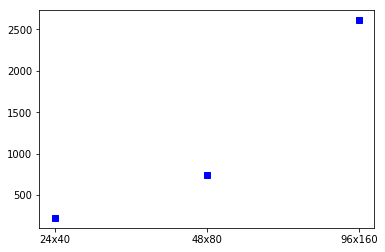

In [77]:
# compare network training and clustering speed
# training_time_arr

x_axis = ['24x40','48x80', '96x160']
y_axis1 = []
y_axis2 = []
y_axis3 = []
for i in range(len(training_time_arr)):
    y_axis1.append(training_time_arr[i][0])
    y_axis2.append(training_time_arr[i][1])
    y_axis3.append(y_axis1[i] + y_axis2[i])
    
plt.plot(x_axis, y_axis3, 'bs')
plt.show()



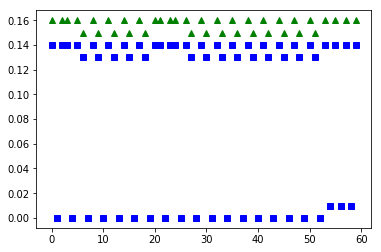

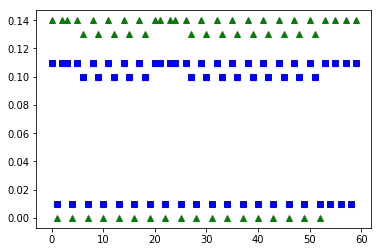

In [78]:
# we want to do a comparison in training speed

def draw_filter_training_speed(union_):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_)):
        if -1 in union_[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_[i][1])
            y_axis2.append(union_[i][3])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()

for i in range(len(union_arr)):
    draw_filter_training_speed(union_arr[i])
    


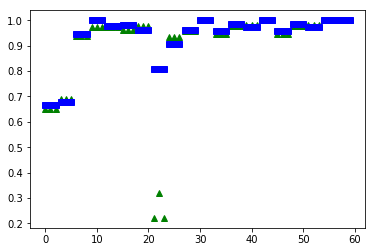

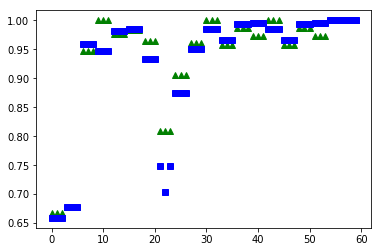

In [79]:
# we want to do a comparison in evaluation accuracy

def draw_filter_accuracy(union_):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_)):
        if -1 in union_[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_[i][0])
            y_axis2.append(union_[i][2])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()
    
for i in range(len(union_arr)):
    union_ = union_arr[i]
    draw_filter_accuracy(union_)

In [84]:
#Comparison for only non random rows

def create_union_nonrandom(stats_arr, stats_arr_rep, row_names, row_names_rep):

    union_1 = np.zeros(shape = (len(row_names),4 ))

    index = 0
    new_row_names = []
    for idx,row_name in enumerate(row_names):
        if ("t=" in row_name) or ("s=" in row_name):
            union_1[index,0] = stats_arr[idx][0]
            union_1[index,1] = stats_arr[idx][1]
            new_row_names.append(row_name)
            if row_name not in row_names_rep:
                union_1[index, 2] = -1
                union_1[index, 3] = -1
            else:
                corresponding_idx = row_names_rep.index(row_name)
                union_1[index,2] = stats_arr_rep[corresponding_idx][0]
                union_1[index,3] = stats_arr_rep[corresponding_idx][1]
            index += 1

    
    return union_1

union_1_arr = []

for i in range(len(stats_arr_rep_arr) - 1):
    union_1 = create_union_nonrandom(stats_arr_rep_arr[i], stats_arr_rep_arr[i+1], row_names_arr[i], row_names_arr[i+1])
    union_1_arr.append(union_1)
    



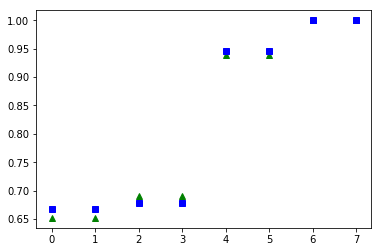

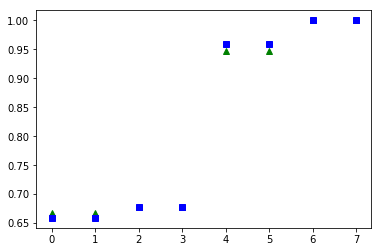

In [85]:
# we want to do a comparison in evaluation accuracy

def draw_accuracy_non_random(union_1):
    x_axis = []
    y_axis1 = []
    y_axis2 = []
    curr_num = 0
    for i in range(len(union_1)):
        if -1 in union_1[i]:
            continue
        elif 0 in union_1[i]:
            continue
        else:
            x_axis.append(curr_num)
            y_axis1.append(union_1[i][0])
            y_axis2.append(union_1[i][2])
            curr_num += 1

    plt.plot(x_axis, y_axis1, 'g^', x_axis, y_axis2, 'bs')
    plt.show()
    
for i in range(len(union_1_arr)):
    draw_accuracy_non_random(union_1_arr[i])

In [87]:
def print_analysis(union_, union_1, prev, curr):
    print("------------------------------")
    union_formatted = union_[1:, :]
    avg_speed_original = sum(union_formatted[:, 1]) / len(union_formatted[:,1])
    avg_speed_new = sum(union_formatted[:, 3]) / len(union_formatted[:,3])

    print("avg time for",prev,"pipeline", round(avg_speed_original,3), "seconds")
    print("avg time for",curr,"pipeline", round(avg_speed_new,3), "seconds")
    print(curr," pipeline is", round(avg_speed_original / avg_speed_new,3), "times faster")
    avg_accuracy_original = sum(union_formatted[:,0]) / len(union_formatted[:,0])
    avg_accuracy_new = sum(union_formatted[:,2]) / len(union_formatted[:,2])
    print("avg accuracy for",prev,"pipeline", round(avg_accuracy_original,3), "%")
    print("avg accuracy for",curr,"pipeline", round(avg_accuracy_new,3), "%")
    print("avg accuracy for",curr," is ", round(avg_accuracy_original - avg_accuracy_new,3),"worse than",prev," (Note if negative, it means it is better!)")

    union_formatted2 = union_1[1:12,:]
    avg_accuracy_original_ = sum(union_formatted2[:,0]) / len(union_formatted2[:,0])
    avg_accuracy_new_ = sum(union_formatted2[:,2]) / len(union_formatted2[:,2])
    print("avg accuracy for non random columns of",prev," pipeline", round(avg_accuracy_original_,3), "%")
    print("avg accuracy for non random columns of",curr," pipeline", round(avg_accuracy_new_,3), "%")
    print("avg accuracy for",curr," is ", round(avg_accuracy_original_ - avg_accuracy_new_,3),"worse than",prev, " (Note if negative, it means it is better!)")
    
x_axis = ['24x40','48x80', '96x160']
for i in range(len(union_arr)):
    print_analysis(union_arr[i], union_1_arr[i], x_axis[i],x_axis[i+1])
    

------------------------------
avg time for 24x40 pipeline 0.101 seconds
avg time for 48x80 pipeline 0.088 seconds
48x80  pipeline is 1.146 times faster
avg accuracy for 24x40 pipeline 0.91 %
avg accuracy for 48x80 pipeline 0.941 %
avg accuracy for 48x80  is  -0.031 worse than 24x40  (Note if negative, it means it is better!)
avg accuracy for non random columns of 24x40  pipeline 0.745 %
avg accuracy for non random columns of 48x80  pipeline 0.746 %
avg accuracy for 48x80  is  -0.002 worse than 24x40  (Note if negative, it means it is better!)
------------------------------
avg time for 48x80 pipeline 0.088 seconds
avg time for 96x160 pipeline 0.072 seconds
96x160  pipeline is 1.226 times faster
avg accuracy for 48x80 pipeline 0.941 %
avg accuracy for 96x160 pipeline 0.933 %
avg accuracy for 96x160  is  0.007 worse than 48x80  (Note if negative, it means it is better!)
avg accuracy for non random columns of 48x80  pipeline 0.746 %
avg accuracy for non random columns of 96x160  pipeline

In [88]:
print(training_time_arr)

[[215.65234923362732, 7.621194839477539], [737.9186794757843, 7.392591953277588], [2600.757129907608, 9.338385581970215]]
